# Worksheet 2: Inference with two parameters

This time, let's assume we don't know the *phase* of the sine curve, either. Our model is now

$
m(P) = 1 + 0.1 \sin\left(\frac{2\pi}{P} t + \phi\right)
$

where (as before) $m$ is the model, $P$ is the period, $t$ is time, and now $\phi$ is a phase offset in radians.

## 1. Import the modules we'll need

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

## 2. Load the dataset
It's stored in the text file ``data/worksheet2.txt``. We'll load the time array ``time``, the flux array ``flux``, and the array of uncertainties ``err``:

In [2]:
time, flux, err = np.loadtxt("data/worksheet2.txt").T

## 3. Plot the dataset
Plot the dataset (flux versus time) to visualize what we're dealing with, and eyeball the value of the period from the plot.

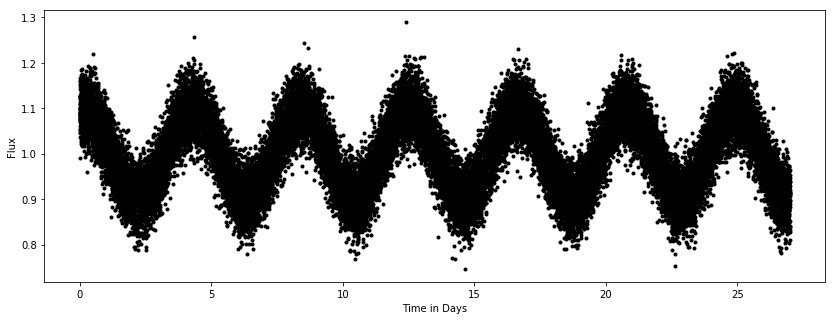

In [8]:
plt.figure(figsize=(14,5)) # width height
plt.plot(time,flux, marker='.', linestyle='', color='black')
plt.xlabel('Time in Days')
plt.ylabel('Flux');

## 4. Define our model

Write a function that returns the model we are going to fit to the data. In this case, the model $m$ is a function of *two* variables, the period $P$ and phase $\phi$, whose values we're going to try to infer.

```python
def model(period, phase):
    return (...)
```

In [9]:
def model(period,phase):
    return  1 + 0.1*np.sin(((2*np.pi)/period)*time+phase)

## 5. Grid search for the period and phase

As before, define an array of ``1,000`` periods over a range that's large enough to include the true period of the dataset. Call this array ``periods``. Also define an array of ``1,000`` phases that spans the range $[0, 2\pi]$ and call it ``phases``. For each *pair of values*, compute the model and the chi-squared ($\chi^2$) value of that model. Store the chi-squared in the two-dimensional array ``chisq``, where ``chisq[i, j]`` corresponds to the chi-squared of the ``ith`` period and the ``jth`` phase.

As before, time the cell by adding

```python
%%time
```

to the top of the cell. How much slower did it run (be patient!)?

In [14]:
import tqdm
from tqdm import tqdm

In [16]:
periods = np.linspace(4,10,1000)
phases = np.linspace(0, 2*np.pi, 1000)
chisq = np.empty((len(periods), (len(phases)))) #DO NOT USE EMPTY_LIKE HERE IT WILL NOT RUN
                      
for i, period in tqdm(enumerate(periods), total=1000):
    for j, phase in enumerate(phases):
        chisq[i,j] = np.sum((model(period, phase) - flux) ** 2)
                       


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [06:29<00:00,  2.71it/s]


## 6. Plot $\chi^2$

This time $\chi^2$ is two-dimensional, so we need to plot a heatmap. Do this by running 

```python
plt.imshow(chisq, origin='lower', extent=extent)
```

where ``extent = (phases.min(), phases.max(), periods.min(), periods.max())``. The phases should be along the horizontal axis, and the periods along the vertical axis.

Identify the minimum in the plot and record the corresponding values of the period and phase.

In [19]:
extent = (phases.min(), phases.max(), periods.min(), periods.max())
best_i, best_j = np.unravel_index(np.argmin(chisq, axis=None), chisq.shape)
best_period = periods[best_i]
best_phase = phases[best_j]
plt.axvline(best_phase, color="k")
plt.axhline(best_period, color="k")
plt.title("$P$ = {:.3f} days ; $\phi$ = {:.3f} radians".format(best_period, best_phase))
plt.imshow(chisq, origin="lower", extent=extent)
plt.colorbar(label=r"$\chi^2$")
plt.xlabel("Phase [radians]")
plt.ylabel("Period [days]");



##WILLNOT RUN!!!!!!!

extent=(phases.min(), phases.max(), periods.min(), periods.max())
statistical_i= np.unravel_index(np.argmin(chisq, axis=None), chisq.shape)
statistial_j=  np.unravel_index(np.argmin(chisq, axis=None), chisq.shape)
bestperiod = periods[statistical_i]
bestphase = phases[statistical_j]
plt.axvline(bestperiod, linestyle='--', color='black')
plt.axhline(bestphase, linestyle='--', color='black')
plt.title('$P$ = {:.3f} days; $\phi$ = {:.3f} radians' .format(bestperiod,bestphase))
plt.xlabel('Phase in Radians')
plt.ylabel('Period in Days')
plt.imshow(chisq, origin='lower', extent=extent )
plt.colorbar(label='$chi^2$')

## np.unravel_index is used to convert linear indices to indexes along the axis of the shape

IndexError: too many indices for array

In [18]:
print(statistical_i)

(20, 211)


## 7. Plot the likelihood

On the same kind of 2-d heat map, plot the likelihood function as we did in the first worksheet. Zoom in on the region of highest likelihood.

(4, 4.2)

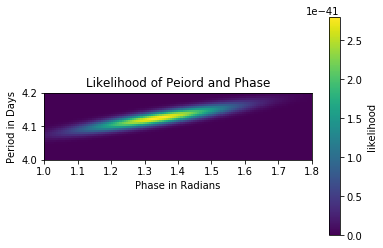

In [75]:
likelihood = np.exp(-0.5 * chisq-chisq.min())
plt.imshow(likelihood, origin='lower', extent=extent)
plt.colorbar(label='likelihood')
plt.title('Likelihood of Peiord and Phase')
plt.xlabel('Phase in Radians')
plt.ylabel('Period in Days')
#plt.x/ylim sets the bounds of the x and y axis
plt.xlim(1,1.8)
plt.ylim(4,4.2)

#heatmap code to fit to 

## 8. Fit a Gaussian
As before, let's fit a Gaussian to the likelihood so we can obtain an uncertainty on each of the parameters. The tricky bit is that our function is two-dimensional, which makes fitting it a pain (at least in the way we did it before). To keep things simple, and to introduce a concept that will be useful later on, let's collapse the likelihood plot above into two one-dimensional plots representing the likelihood of the period and of the phase, respectively, **independently** of the value of the other parameter. In other words, let's compute the projection of the two-dimensional distribution above onto each axis -- you can think of this as the "shadow" of the blob if I were to shine a flashlight on it, pointing toward the `x` and then the `y` axes. Each of these shadows is a Gaussian, so we can solve for the mean and standard deviation of the period and the phase separately by fitting the two 1-dimensional curves individually.

This process of collapsing is called *marginalization*, and it's super simple. To compute the *marginal likelihood* of one variable, we just *sum* over the likelihood at every value of the *other variable*. For example, the marginal likelihood of the phase is

```python
like_phases = np.sum(likelihood, axis=0)
```

and the marginal likelihood of the period is

```python
like_periods = np.sum(likelihood, axis=1)
```

Define the gaussian function as we did in the previous worksheet and fit it to the marginal likelihood of each parameter to arrive at the mean and standard deviation of the period and phase. Overplot both gaussians on the marginal likelihood curves to check that you got a good fit.

In [82]:
## WONT WORK BECAUSE THE CELL TWO UP DOES NOT RUN


def Gaussian(x,mu,sigma):
    return no.exp(-(x-mu)**2/(2*sigma**2))

like_phases = np.sum(likelihood, axis=0)
like_periods = np.sum(likelihood, axis=1)

coeff,_= curve_fit(Gaussian, phases, like_phases, p0=[bestphase, 0.1])  #used the best period found
mu, sigma =  coeff

like_phases = np.sum(likelihood, axis=0)
like_periods = np.sum(likelihood, axis=1)

likelihood = np.exp(-0.5 * chisq-chisq.min())
plt.plot(phases, likelihood, color='black', label='Likelihood')
plt.plot(phases, Gaussian(phases,mu,sigma), color='magenta', label='Gaussian')  #replace x with periods
plt.xlabel('Period')
plt.ylabel('likelihood')
plt.title("$P = {:.3f} \pm {:.4f}$ days".format(mu, sigma));  
plt.legend()
plt.show()

NameError: name 'bestphase' is not defined

## 10. Plot our best model w/ uncertainties
Finally, let's compute the model we defined above using the values of the period and phase we obtained, and overplot it on the data. Is it a good fit?

Don't bother trying to plot the uncertainty (as we did before with ``plt.fill_between``) since in two dimensions things are a little tricker. We'll talk about that next time.

Text(0.5, 1.0, 'Whacky Not Well Algined Graph')

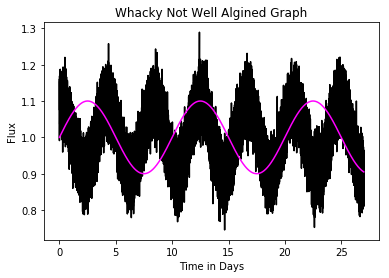

In [88]:
plt.plot(time, flux, color='black', label='Data', markersize=2 ) #zorder means to push or pull one of the lines forward or back/ontop behind the other lines 
plt.plot(time, model(period,phase), color='magenta', label='Model')
plt.xlabel('Time in Days')
plt.ylabel('Flux')
plt.title('Whacky Not Well Algined Graph')

## i think once i figure out what went wrong in that one cell, i can figure out why this has turned out so poorly.

## 11. Higher dimensions
Looking back at how long it took to solve for the parameters of the model in the 1-d case (Worksheet 1) and the 2-d case (Worksheet 2), what can you predict about how long it would take to fit a model with 3 parameters using this method? At what point would it become effectively impossible to do this? When modeling light curves, there are usually a dozen -- or even dozens -- of variables to solve for. Is it feasible to model light curves this way? If not, think about how we might actually do inference in practice.